In [2]:
# Loading libraries
library(phyloseq)
library(DESeq2)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(wesanderson)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The followin

### Comparing OTUs that respond in any study 

In [39]:
# One option for combining all the datasets would be to run deseq on each dataset separately,
# possibly controlling for relevant factors in their experimental designs - timepoints, rates, chars, etc.
# Then, we could pull out all the OTUs that were responsive under any of the conditions
# We could collect those OTUs as responder OTUs, and then combine them across all studies.
# Then, we could do a few things - we could make a responder plot for each study. That would just replicate past work
# On the other hand, we could combine the responders. Maybe we go back to the full dataset
# For each genus, family, phylum, etc., we could look in the datasets and ask, how many OTUs within this group
# responded to PyOM (under some condition)? We would also ask, how many OTUs within this group were present at all?
# Then, we could scan that list and say, first, how many studies found responders in this group?
# If we find responders across many studies, that might suggest that is an organism group of interest.
# Then, we might get into what fraction of the community they make up.

#### First, considering each study individually, so we are detecting OTUs

In [3]:
# Read in the phyloseq objects
ps.wu = readRDS(file = "wu.ps")
ps.imparato = readRDS(file = "imparato.ps")
ps.yao = readRDS(file = "yao.ps")
ps.dai2016 = readRDS(file = "dai2016.ps")
ps.dai2017 = readRDS(file = "dai2017.ps")
ps.song = readRDS(file = "song.ps")
ps.whitman = readRDS(file = "whitman.ps")
ps.ye = readRDS(file = "ps.ye")
ps.nielsen2014 = readRDS(file = "ps.nielsen2014")
ps.xu = readRDS(file = "ps.xu")

In [89]:
pslist=list(ps.wu,ps.imparato,ps.yao,ps.dai2016,ps.dai2017,ps.song,ps.whitman,ps.ye,ps.nielsen2014,ps.xu)
# Creating list of all studies' phyloseq objects

In [93]:
n = 1
ps.full.list = list()
for (i in 1:length(pslist)){
    ps = pslist[[i]]
    ps = subset_samples(ps, is.na(Incubation_Time_Weeks) | Incubation_Time_Weeks != 0)
    # Make sure not initial sample
    ps = subset_samples(ps, PyOM %in% c("PyOM","Control"))
    # Make sure only PyOM and control

    sample_data(ps)$SoilTypeName = paste(sample_data(ps)$SoilType," (",sample_data(ps)$Author,")",sep="")
    # Create a variable that separates by studies / soil type

    sample_data(ps)$Feedstock_Category = ifelse(sample_data(ps)$Feedstock %in% c('commercial cornstock powder', 'corn stover', 'corncob',"Corn Straw"), "Corn",
                                           ifelse(sample_data(ps)$Feedstock %in% c('wheat straw','winter wheat'),"Wheat",
                                                ifelse(sample_data(ps)$Feedstock %in% c('Jarrah wood'),"Eucalyptus",
                                                 ifelse(sample_data(ps)$Feedstock =='Manure', "Manure","Unknown"))))
    # Rename the feedstocks for consistency

    sample_data(ps)$CharType = ifelse(sample_data(ps)$PyOM=="PyOM",paste(sample_data(ps)$Feedstock_Category,sample_data(ps)$PyOM.Temp,sep=""),"Control")
    
    ps = subset_samples(ps, !(Author == "Song" & SoilType == "Gleysol" & Incubation_Time_Weeks == 24))
    # Removing one set of samples that we know doesn't have a control
    
    pslist[[i]] = ps
    # Updates list of all the phyloseq objects for the studies.    

    Studies = levels(as.factor(sample_data(ps)$SoilTypeName))

    for (m in 1:length(Studies)) {
        STN = Studies[m]
        ps.study = subset_samples(ps, sample_data(ps)$SoilTypeName==STN)
        Dates = levels(as.factor(sample_data(ps.study)$Incubation_Time_Weeks))    
        for (j in 1:length(Dates)){
            DATE = Dates[j]
            ps.date = subset_samples(ps.study, sample_data(ps)$Incubation_Time_Weeks==DATE)
            Chars = levels(as.factor(sample_data(ps.date)$CharType))
            for (k in 2:length(Chars)){
            # This works because "Control" is always first in these datasets. Not great coding.
              CHAR = Chars[k]
              ps.date.char = subset_samples(ps.date,(sample_data(ps.date)$CharType==CHAR | sample_data(ps.date)$CharType=="Control"))
              ps.date.char = subset_samples(ps.date.char,(sample_sums(ps.date.char)>1000))
              ps.date.char = prune_taxa(taxa_sums(ps.date.char)>0, ps.date.char)
              # Remove nonexistent taxa
              ps.full.list[[n]]=ps.date.char
              n=n+1
            }
        }
    }
}
# Creating a series of ps objects for each combination of char types and dates. (Rates not considered separately)
# This set is for each full dataset individually (OTU-level)

In [94]:
ps.runner = function(ps){
    ps = ps
    SoilTypeName = paste(levels(as.factor(sample_data(ps)$SoilTypeName)))
    CharType = paste(levels(as.factor(sample_data(ps)$CharType))[2])
    Incubation_Time_Weeks = paste(levels(as.factor(sample_data(ps)$Incubation_Time_Weeks)))
    dseq = phyloseq_to_deseq2(ps, ~PyOM)
    dseq$PyOM = relevel(dseq$PyOM,"Control")
    
    result = try(DESeq(dseq, quiet = TRUE, fitType = "local"), silent=TRUE)
    # Try running the function.
    
    # If there's an error, use the geometric mean for DESEq2:
    if(class(result)=="try-error"){
        # If there is an error due to sparse counts, can use geometric mean
        # See https://github.com/joey711/phyloseq/issues/387
    
        # calculate geometric means prior to estimate size factors
        gm_mean = function(x, na.rm=TRUE){
          exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
            }    
        geoMeans = apply(counts(dseq), 1, gm_mean)
        dseq = estimateSizeFactors(dseq, geoMeans = geoMeans)
        dseq = DESeq(dseq, quiet=TRUE, fitType="local")
        }

    # If it's fine, then proceed.
    if (class(result) != "try-error") {
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    }
    
    #taxonomy = data.frame(tax_table(ps))
    
    taxonomy = as(tax_table(ps), "matrix")
    taxonomy = as.data.frame(taxonomy)
    
    results = results(dseq)
    results = data.frame(SoilTypeName,CharType,Incubation_Time_Weeks,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy)
    colnames(results)[1:8] = c("SoilTypeName","CharType","Incubation_Time_Weeks","OTU","baseMean","l2FC","SE","pvalue")
    DA = results
    return(DA)
    }
# Creating the function to run DESeq2 on the ps objects

In [97]:
ps.list.output = list()

#for (i in c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20)){
for (i in 1:length(ps.full.list)){
  ps = ps.full.list[[i]]
  # Getting the ps object
  comparison_test=ps.runner(ps)
  # Run the analysis
  ps.list.output[[i]]=comparison_test
}
# Running the function on all ps objects

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are ch

In [98]:
#saveRDS(ps.list.output,"ps.list.output")
ps.list.output = readRDS("ps.list.output")

In [99]:
# Make one giant dataframe of everything
DA = rbind(ps.list.output[[1]],ps.list.output[[2]],ps.list.output[[3]],ps.list.output[[4]],ps.list.output[[5]],
          ps.list.output[[6]],ps.list.output[[7]],ps.list.output[[8]],ps.list.output[[9]],ps.list.output[[10]],
          ps.list.output[[11]],ps.list.output[[12]],ps.list.output[[13]],ps.list.output[[14]],ps.list.output[[15]],
          ps.list.output[[16]],ps.list.output[[17]],ps.list.output[[18]],ps.list.output[[19]],ps.list.output[[20]],
          ps.list.output[[21]])

In [100]:
DA = DA %>%
    group_by(SoilTypeName,CharType,Incubation_Time_Weeks)%>%
    mutate(RelAbund = baseMean/sum(baseMean))%>%
    group_by()
# Add a rough relative abundance column (for all samples in dataset)

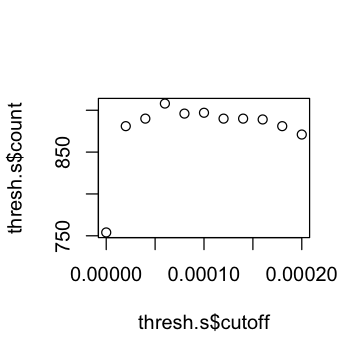

In [101]:
### We need to adjust for allll of these multiple comparisons together

options(repr.plot.width=3, repr.plot.height=3)

# Independent filtering
threshold = function (thresh){
    dplyr::summarize(dplyr::mutate(dplyr::filter(DA, RelAbund >= thresh), padj = p.adjust(pvalue,"BH")),cutoff=thresh, count=sum(padj<=0.05, na.rm = TRUE))
}

range = seq(0,0.0002,0.00002)
# Creates a range of numbers we are interested in for adjusted p values

thresh.s = plyr::ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here at the peak of the graph - 0.00008

In [102]:
cutoff = 0.00006
pval = 0.05

DA = dplyr::filter(DA,RelAbund>=cutoff)
# Filter out low-abundance OTUs
DA = dplyr::mutate(DA, padj = p.adjust(pvalue,"BH"))
# Adjust remaining pvalues for multiple comparisons across the entire dataset
DA = dplyr::mutate(DA, Sig = ifelse(padj<pval,"significant","not significant"))
# Add a column designating significance

d = DA

In [103]:
levels(d$SoilTypeName)

[1] "Gleysol (Wu)"         "Luvisol (Imparato)"   "Mollisol (Yao)"      
 [4] "Inceptisol (Dai)"     "Argiustoll (Dai)"     "Psammaquent (Dai)"   
 [7] "Gleysol (Song)"       "Fragiudept (Whitman)" "Fluvisol (Ye)"       
[10] "Ferralsol (Nielsen)"  "Cambisol (Xu)"

In [104]:
d = d %>%
    dplyr::filter(!is.na(Sig))
# Remove untested taxa

cutoff = 2
# Minimum number of studies in which a genus must be significant to plot

SigPhy = d %>%
    filter(padj<pval)%>%
    filter(l2FC>0)%>%
    group_by(SoilTypeName,Genus)%>%
    summarize(TotalSigOTUs = n())%>%
    arrange(Genus,-TotalSigOTUs)%>%
    group_by(Genus)%>%
    summarize(TotalStudies=n())%>%
    arrange(-TotalStudies)%>%
    filter(TotalStudies >= cutoff)
# Makes a data frame of the total soil types/studies in which each taxon was significant positive responder

d = d %>%
    dplyr::filter(Genus %in% SigPhy$Genus)
# Keep only genera that were significant in at least one study

d$OTUName = paste(d$Genus," (", d$Phylum,")",sep="")
d$OTUNameClass = paste(d$Genus," (", substr(d$Class,1,5),")",sep="")
d$OTUNameOrder = paste(d$Genus," (", d$Order,")",sep="")
# Just some category naming for graphing

Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”

In [105]:
cutoff = 4
# Minimum number of studies a genus must be present in to plot

nStudies = d %>%
    group_by(Genus,SoilTypeName)%>%
    summarize(N=n())%>%
    arrange(-N)%>%
    group_by(Genus)%>%
    summarize(NStudies=n())%>%
    arrange(-NStudies)%>%
    filter(NStudies>=cutoff)
#nStudies in which it is present

dim(d)
d = d %>%
    filter(Genus %in% nStudies$Genus)
# Filter so we only look at genera that include at least one significant responder
# and that are also present in at least [cutoff] studies

dim(d)

Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”

[1] 18351    21

[1] 18232    21

In [106]:
nStudies

Genus,NStudies
<fct>,<int>
metagenome,11
Phenylobacterium,11
Sphingomonas,11
uncultured,11
uncultured bacterium,11
NA,11
Bryobacter,10
Candidatus Solibacter,10
Nocardioides,10


In [107]:
length(SigPhy$Genus)
length(nStudies$Genus)

[1] 41

[1] 36

In [108]:
GenusOrder = d %>%
    group_by(Genus,Phylum)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Phylum,-Max)%>%
    filter(!(Genus %in% c(NA, "uncultured","metagenome","uncultured bacterium","Ambiguous_taxa","uncultured soil bacterium","uncultured actinobacterium")))
GenusOrder = GenusOrder$Genus
GenusOrder

Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Phylum` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”

[1] RB41                             Bryobacter                      
 [3] Candidatus Solibacter            Streptomyces                    
 [5] Kribbella                        Nakamurella                     
 [7] Nocardia                         Nocardioides                    
 [9] Micromonospora                   Pseudonocardia                  
[11] Nonomuraea                       Microlunatus                    
[13] Mycobacterium                    Flavisolibacter                 
[15] uncultured Chloroflexi bacterium Bacillus                        
[17] Shimazuella                      Haliangium                      
[19] Sphingomonas                     Ramlibacter                     
[21] Noviherbaspirillum               MND1                            
[23] Microvirga                       Reyranella                      
[25] Mesorhizobium                    Rhodoplanes                     
[27] Pseudolabrys                     Phenylobacterium                
[29] Lysobacter                       Ellin6067                       
[31] Brevundimonas                   
824 Levels: Agromyces Altererythrobacter Anaerolinea Arcicella ... uncultured Thermoanaerobacteraceae bacterium

In [109]:
OTUNameOrder = d %>%
    group_by(Phylum,OTUName)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Phylum,-Max)
OTUNameOrder=paste(OTUNameOrder$OTUName)
d$OTUName = factor(d$OTUName,levels=OTUNameOrder)

GenusOrder = d %>%
    group_by(Genus,Phylum)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Phylum,-Max)%>%
    filter(!(Genus %in% c(NA, "uncultured","metagenome","uncultured bacterium","Ambiguous_taxa","uncultured soil bacterium","uncultured actinobacterium")))
GenusOrder=paste(GenusOrder$Genus)
d$Genus = factor(d$Genus,levels=GenusOrder)

OTUNameClassOrder = d %>%
    group_by(OTUNameClass)%>%
    summarize(Max = max(l2FC))%>%
    arrange(-Max)
OTUNameClassOrder=paste(OTUNameClassOrder$OTUNameClass)
d$OTUNameClass = factor(d$OTUNameClass,levels=OTUNameClassOrder)

OTUNameOrderOrder = d %>%
    group_by(Order,OTUNameOrder)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Order,-Max)
OTUNameOrderOrder=paste(OTUNameOrderOrder$OTUNameOrder)
d$OTUNameOrder = factor(d$OTUNameOrder,levels=OTUNameOrderOrder)

d.AllPhy = d %>%
    filter(!(Genus %in% c(NA, "uncultured","metagenome","uncultured bacterium","Ambiguous_taxa","uncultured soil bacterium","uncultured actinobacterium","uncultured Chloroflexi bacterium")))

d.OtherPhy = d %>%
    filter(!(Genus %in% c(NA, "uncultured","metagenome","uncultured bacterium","Ambiguous_taxa","uncultured soil bacterium","uncultured actinobacterium")))%>%
    filter(Phylum %in% c("Acidobacteria","Bacteroidetes","Chloroflexi","Firmicutes","Gemmatimonadetes","Nitrospirae",
                        "Planctomycetes","Thaumarchaeota","Verrucomicrobia"))#%>%
    #filter(OTUName != "Symbiobacterium (Firmicutes)")
d.Proteo = d%>%
    filter(!(Genus %in% c(NA, "uncultured","metagenome","uncultured bacterium","Ambiguous_taxa","uncultured soil bacterium","uncultured actinobacterium")))%>%
    filter(Phylum=="Proteobacteria")%>%
    mutate(OTUNameClass = ifelse(OTUNameClass=="Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium (Alpha)","Allo/Neo/Para-Rhizobium (Alpha)",paste(OTUNameClass)))%>%
    mutate(Genus = ifelse(Genus=="Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium","Allo/Neo/Para-Rhizobium",paste(Genus)))
d.Actino = d%>%
    filter(!(Genus %in% c(NA, "uncultured","metagenome","uncultured bacterium","Ambiguous_taxa","uncultured soil bacterium","uncultured actinobacterium")))%>%
    filter(Phylum=="Actinobacteria")
d.Whitman = d%>%
    filter(!(Genus %in% c(NA, "uncultured","metagenome","uncultured bacterium","Ambiguous_taxa","uncultured soil bacterium","uncultured actinobacterium")))%>%
    filter(SoilTypeName=="Fragiudept (Whitman)")

OTUNameClassOrder = d.Proteo %>%
    group_by(Class,Genus)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Class,-Max)
OTUNameClassOrder=paste(OTUNameClassOrder$Genus)
d.Proteo$Genus = factor(d.Proteo$Genus,levels=OTUNameClassOrder)

OTUNameClassOrder = d.Actino %>%
    group_by(Order,Genus)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Order,-Max)
OTUNameClassOrder=paste(OTUNameClassOrder$Genus)
d.Actino$Genus = factor(d.Actino$Genus,levels=OTUNameClassOrder)

d.AllAcido = d %>%
    filter(Phylum=="Acidobacteria")

Warning message:
“Factor `Phylum` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Phylum` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Phylum` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Genus` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Order` contains implicit NA, consider using `forcats::fct_explicit_na`”Warning message:
“Factor `Order` contains implicit NA, consider using `forcats::fct_explicit_na`”

Warning message:
“Removed 19 rows containing non-finite values (stat_boxplot).”

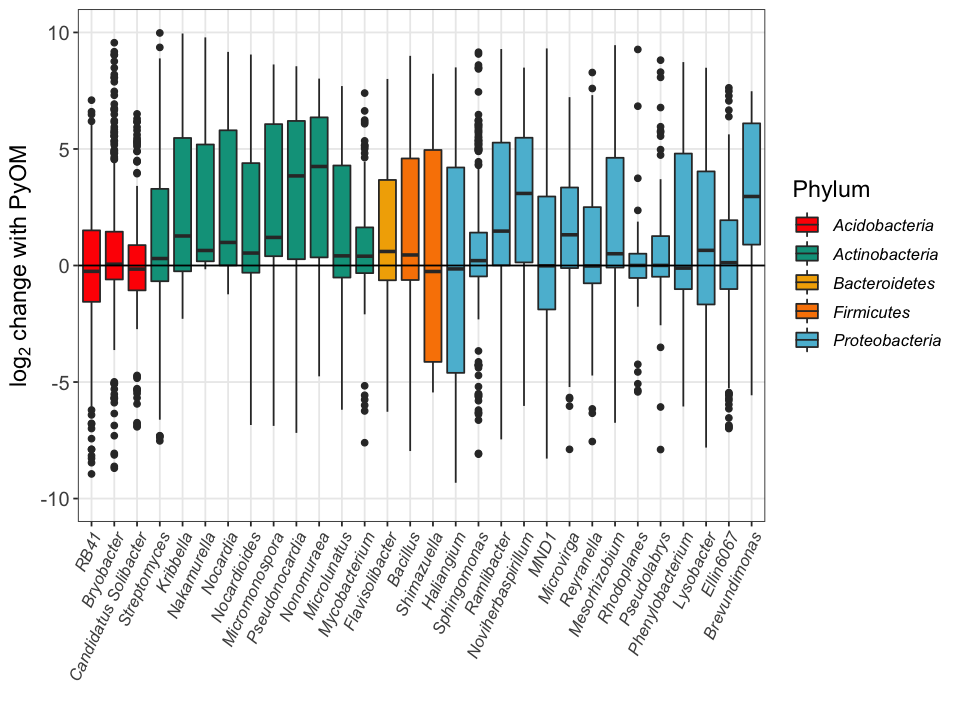

In [110]:
options(repr.plot.width=8, repr.plot.height=6)

palette = c(wes_palette("Darjeeling1"),"grey","white")

p = ggplot(d.AllPhy, aes(x = Genus, y = l2FC, fill=Phylum))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being phylum, relative size proportional to mean abundance, and alpha (transparency) based on
# whether or not the adjusted p value is significant.
p = p + geom_boxplot() # Using shape=21 to get the option that has an outline and a fill colour
p = p + theme_bw()
# sets a theme - adjusts a bunch of aesthetics at once
p = p + theme(strip.text.x = element_text(size = 14),
              strip.text.y = element_text(size = 14),
              axis.text.x = element_text(size = 10, angle = 65, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 14),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 10, face="italic"),
              #legend.position = "none",
              strip.background = element_blank()
              ) + 
        guides(size=FALSE, alpha=FALSE, fill=guide_legend(title="Phylum"))
p = p + scale_alpha_manual(values=c(0.2,0.9))
p = p + scale_fill_manual(values=palette)
# sets a bunch of visual paramters for the legend (none) and other text
p = p + labs(x = "")
# sets the label for the x axis.
p = p + labs(y = expression(paste("", log[2]," change with PyOM",sep="")))
# sets the label for the y axes.
p = p + theme(panel.grid.minor = element_blank())
# Gets rid of the default gridlines
p = p + geom_hline(yintercept=0)
p = p + ylim(c(-10,10))

p

Warning message:
“Removed 19 rows containing missing values (geom_point).”

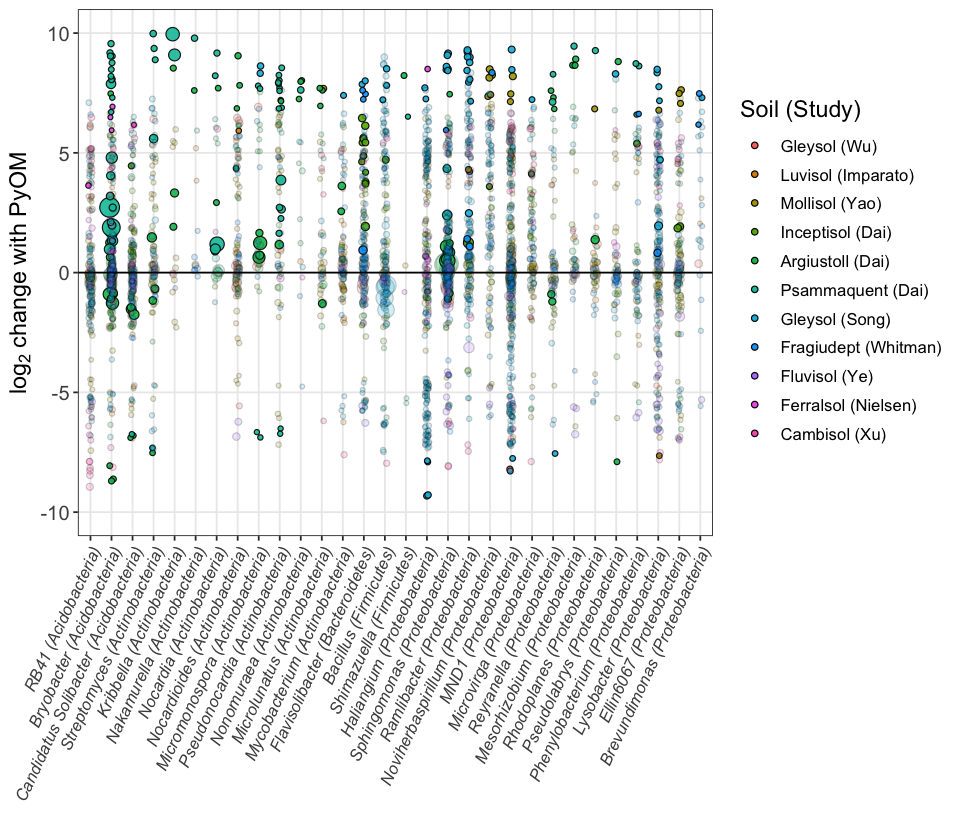

In [111]:
options(repr.plot.width=8, repr.plot.height=7)

p = ggplot(d.AllPhy, aes(x = OTUName, y = l2FC, fill=SoilTypeName, size = RelAbund, alpha=Sig))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being phylum, relative size proportional to mean abundance, and alpha (transparency) based on
# whether or not the adjusted p value is significant.
p = p + geom_jitter(shape=21, width=0.1) # Using shape=21 to get the option that has an outline and a fill colour
p = p + theme_bw()
# sets a theme - adjusts a bunch of aesthetics at once
p = p + theme(strip.text.x = element_text(size = 14),
              strip.text.y = element_text(size = 14),
              axis.text.x = element_text(size = 10, angle = 65, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 14),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 10),
              #legend.position = "none",
              strip.background = element_blank()
              ) + 
        guides(size=FALSE, alpha=FALSE, fill=guide_legend(title="Soil (Study)"))
p = p + scale_alpha_manual(values=c(0.2,0.9))
# sets a bunch of visual paramters for the legend (none) and other text
p = p + labs(x = "")
# sets the label for the x axis.
p = p + labs(y = expression(paste("", log[2]," change with PyOM",sep="")))
# sets the label for the y axes.
p = p + theme(panel.grid.minor = element_blank())
# Gets rid of the default gridlines
p = p + geom_hline(yintercept=0)
p = p + ylim(c(-10,10))
#p = p + facet_wrap(~Phylum, scales="free",ncol=4)

p

## Now running the same analysis on the glommed genus data

In [33]:
ps = readRDS("ps.glom.genus.ps")
# Import ps object
ps = subset_samples(ps, Incubation_Time_Weeks != 0)
ps = subset_samples(ps, PyOM != "OM")
# Remove the initial measurements and the OM only treatments

sample_data(ps)$SoilTypeName = paste(sample_data(ps)$SoilType," (",sample_data(ps)$Author,")",sep="")
# Create a variable that separates by studies / soil type

sample_data(ps)$Feedstock_Category = ifelse(sample_data(ps)$Feedstock %in% c('commercial cornstock powder', 'corn stover', 'corncob',"Corn Straw"), "Corn",
                                   ifelse(sample_data(ps)$Feedstock %in% c('wheat straw','winter wheat'),"Wheat",
                                          ifelse(sample_data(ps)$Feedstock %in% c('Jarrah wood'),"Eucalyptus",
                                                 ifelse(sample_data(ps)$Feedstock =='Manure', "Manure","Unknown"))))
# Rename the feedstocks for consistency

sample_data(ps)$CharType = ifelse(sample_data(ps)$PyOM=="PyOM",paste(sample_data(ps)$Feedstock_Category,sample_data(ps)$PyOM.Temp,sep=""),"Control")
#sample_data(ps)$CharType = ifelse(sample_data(ps)$PyOM=="PyOM",sample_data(ps)$Feedstock_Category,"Control")
levels(as.factor(sample_data(ps)$CharType))
# These are all the PyOM samples we will want to test.

ps = subset_samples(ps, !(Author == "Song" & SoilType == "Gleysol" & Incubation_Time_Weeks == 24))
# Removing one set of samples that we know doesn't have a control

ps.list = list()

Studies = levels(as.factor(sample_data(ps)$SoilTypeName))
n = 1
for (i in 1:length(Studies)) {
  STN = Studies[i]
  ps.study = subset_samples(ps, sample_data(ps)$SoilTypeName==STN)
  Dates = levels(as.factor(sample_data(ps.study)$Incubation_Time_Weeks))
  for (j in 1:length(Dates)){
    DATE = Dates[j]
    ps.study.date = subset_samples(ps.study, sample_data(ps.study)$Incubation_Time_Weeks==DATE)
    Chars = levels(as.factor(sample_data(ps.study)$CharType))
    for (k in 2:length(Chars)){
      CHAR = Chars[k]
      #print(paste(CHAR,DATE,STN))
      ps.study.date.char = subset_samples(ps.study.date,(sample_data(ps.study.date)$CharType==CHAR | sample_data(ps.study.date)$CharType=="Control"))
      ps.list[n]=ps.study.date.char
      n=n+1
    }
  }
}
# Creating a series of ps objects for each combination of char types and dates. (Rates not considered separately)
# This set is for each dataset individually after the glom (genus-level)

[1] "Control"       "Corn"          "Corn350"       "Corn450"      
 [5] "Corn500"       "Eucalyptus600" "Manure300"     "Manure550"    
 [9] "Manure700"     "Unknown550"    "Wheat300"      "Wheat600"     
[13] "Wheat750"

Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.

In [34]:
ps.list

[[1]]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 855 taxa and 6 samples ]
sample_data() Sample Data:       [ 6 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 855 taxa by 7 taxonomic ranks ]

[[2]]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 855 taxa and 6 samples ]
sample_data() Sample Data:       [ 6 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 855 taxa by 7 taxonomic ranks ]

[[3]]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 855 taxa and 5 samples ]
sample_data() Sample Data:       [ 5 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 855 taxa by 7 taxonomic ranks ]

[[4]]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 855 taxa and 42 samples ]
sample_data() Sample Data:       [ 42 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 855 taxa by 7 taxonomic ranks ]

[[5]]
phyloseq-class exper

In [42]:
ps.list.output.genus = list()

#for (i in c(1)){
#for (i in c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20)){
for (i in 1:length(ps.list)){
  ps = ps.list[[i]]
  # Getting the ps object
  comparison_test=ps.runner(ps)
  # Run the analysis
  ps.list.output.genus[[i]]=comparison_test
}
# Running the function on all ps objects

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are ch

In [43]:
#saveRDS(ps.list.output.genus,"ps.list.output.genus")
ps.list.output.genus = readRDS("ps.list.output.genus")

In [44]:
# Make one giant dataframe of everything
DA = rbind(ps.list.output.genus[[1]],ps.list.output.genus[[2]],ps.list.output.genus[[3]],ps.list.output.genus[[4]],ps.list.output.genus[[5]],
          ps.list.output.genus[[6]],ps.list.output.genus[[7]],ps.list.output.genus[[8]],ps.list.output.genus[[9]],ps.list.output.genus[[10]],
          ps.list.output.genus[[11]],ps.list.output.genus[[12]],ps.list.output.genus[[13]],ps.list.output.genus[[14]],ps.list.output.genus[[15]],
          ps.list.output.genus[[16]],ps.list.output.genus[[17]],ps.list.output.genus[[18]],ps.list.output.genus[[19]],ps.list.output.genus[[20]])

In [45]:
DA = DA %>%
    group_by(SoilTypeName,CharType,Incubation_Time_Weeks)%>%
    mutate(RelAbund = baseMean/sum(baseMean))%>%
    group_by()
# Add a rough relative abundance column (for all samples in dataset)

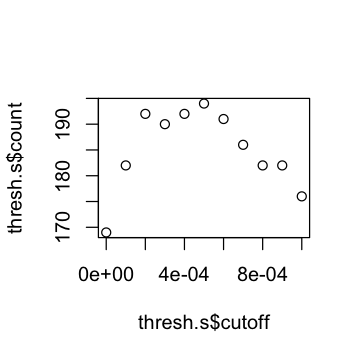

In [46]:
### We need to adjust for allll of these multiple comparisons together

options(repr.plot.width=3, repr.plot.height=3)

# Independent filtering
threshold = function (thresh){
    dplyr::summarize(dplyr::mutate(dplyr::filter(DA, RelAbund >= thresh), padj = p.adjust(pvalue,"BH")),cutoff=thresh, count=sum(padj<=0.05, na.rm = TRUE))
}

range = seq(0,0.001,0.0001)
# Creates a range of numbers we are interested in for adjusted p values

thresh.s = plyr::ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here at the peak of the graph

In [47]:
cutoff = 0.0005
pval = 0.05

DA = dplyr::filter(DA,RelAbund>=cutoff)
# Filter out low-abundance OTUs
DA = dplyr::mutate(DA, padj = p.adjust(pvalue,"BH"))
# Adjust remaining pvalues for multiple comparisons across the entire dataset
DA = dplyr::mutate(DA, Sig = ifelse(padj<pval,"significant","not significant"))
# Add a column designating significance

d = DA

In [48]:
d = d %>%
    dplyr::filter(!is.na(Sig))
# Remove untested taxa

cutoff = 2
# Minimum number of studies in which a genus must be significant to plot

SigPhy = d %>%
    filter(padj<pval)%>%
    filter(l2FC>0)%>%
    group_by(SoilTypeName,Genus)%>%
    summarize(TotalResp = n())%>%
    group_by(Genus)%>%
    summarize(TotalStudies=n())%>%
    arrange(-TotalStudies)%>%
    filter(TotalStudies >= cutoff)
# Makes a data frame of the total soil types/studies in which each taxon was significant positive responder

d = d %>%
    filter(Genus %in% SigPhy$Genus)
# Keep only genera that were significant in at least one study

d = d %>%
    mutate(Genus = ifelse(Genus=="Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium","Allo/Neo/Para-Rhizobium",paste(Genus)))
# Fix weird name

d$OTUName = paste(d$Genus," (", d$Phylum,")",sep="")
d$OTUNameClass = paste(d$Genus," (", substr(d$Class,1,5),")",sep="")
d$OTUNameOrder = paste(d$Genus," (", d$Order,")",sep="")
# Just some category naming for graphing

In [49]:
cutoff = 4
# Minimum number of studies a genus must be present in to plot

nStudies = d %>%
    group_by(Genus,SoilTypeName)%>%
    summarize(N=n())%>%
    arrange(-N)%>%
    group_by(Genus)%>%
    summarize(NStudies=n())%>%
    arrange(-NStudies)%>%
    filter(NStudies>=cutoff)
#nStudies in which it is present

dim(d)
d = d %>%
    filter(Genus %in% nStudies$Genus)
# Filter so we only look at genera that include at least one significant responder
# and that are also present in at least [cutoff] studies

dim(d)

[1] 218  21

[1] 204  21

In [50]:
length(nStudies$Genus)
length(SigPhy$Genus)

[1] 16

[1] 20

In [51]:
OTUNameOrder = d %>%
    group_by(Phylum,OTUName)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Phylum,-Max)
OTUNameOrder=paste(OTUNameOrder$OTUName)
d$OTUName = factor(d$OTUName,levels=OTUNameOrder)

GenusOrder = d %>%
    group_by(Genus,Phylum)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Phylum,-Max)%>%
    filter(!(Genus %in% c(NA, "uncultured","metagenome","uncultured bacterium","Ambiguous_taxa","uncultured soil bacterium","uncultured actinobacterium")))
GenusOrder=paste(GenusOrder$Genus)
d$Genus = factor(d$Genus,levels=GenusOrder)

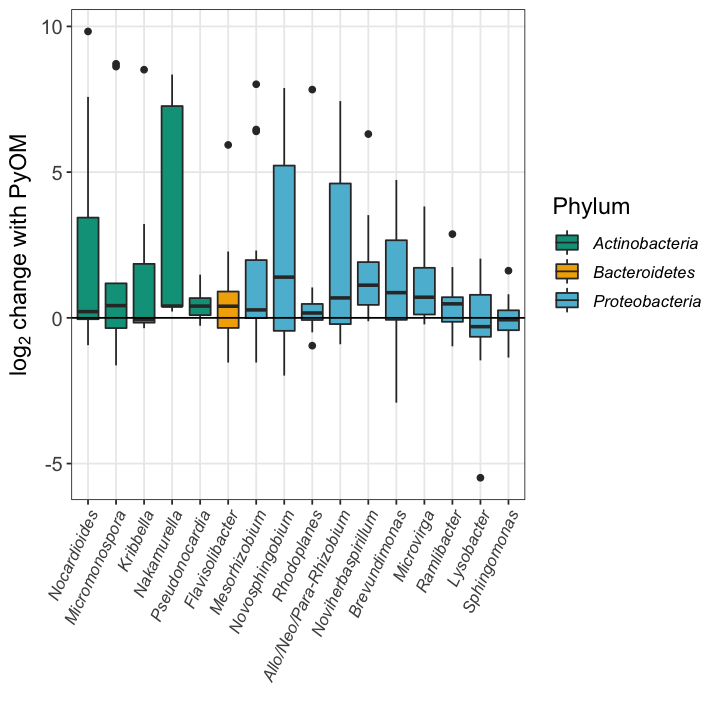

In [53]:
options(repr.plot.width=6, repr.plot.height=6)

palette = c(wes_palette("Darjeeling1"),"grey","white")

p = ggplot(d, aes(x = Genus, y = l2FC, fill=Phylum))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being phylum, relative size proportional to mean abundance, and alpha (transparency) based on
# whether or not the adjusted p value is significant.
p = p + geom_boxplot() # Using shape=21 to get the option that has an outline and a fill colour
p = p + theme_bw()
# sets a theme - adjusts a bunch of aesthetics at once
p = p + theme(strip.text.x = element_text(size = 14),
              strip.text.y = element_text(size = 14),
              axis.text.x = element_text(size = 10, angle = 65, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 14),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 10, face="italic"),
              #legend.position = "none",
              strip.background = element_blank()
              ) + 
        guides(size=FALSE, alpha=FALSE, fill=guide_legend(title="Phylum"))
p = p + scale_alpha_manual(values=c(0.2,0.9))
p = p + scale_fill_manual(values=palette[c(2,3,5)])
# sets a bunch of visual paramters for the legend (none) and other text
p = p + labs(x = "")
# sets the label for the x axis.
p = p + labs(y = expression(paste("", log[2]," change with PyOM",sep="")))
# sets the label for the y axes.
p = p + theme(panel.grid.minor = element_blank())
# Gets rid of the default gridlines
p = p + geom_hline(yintercept=0)

p

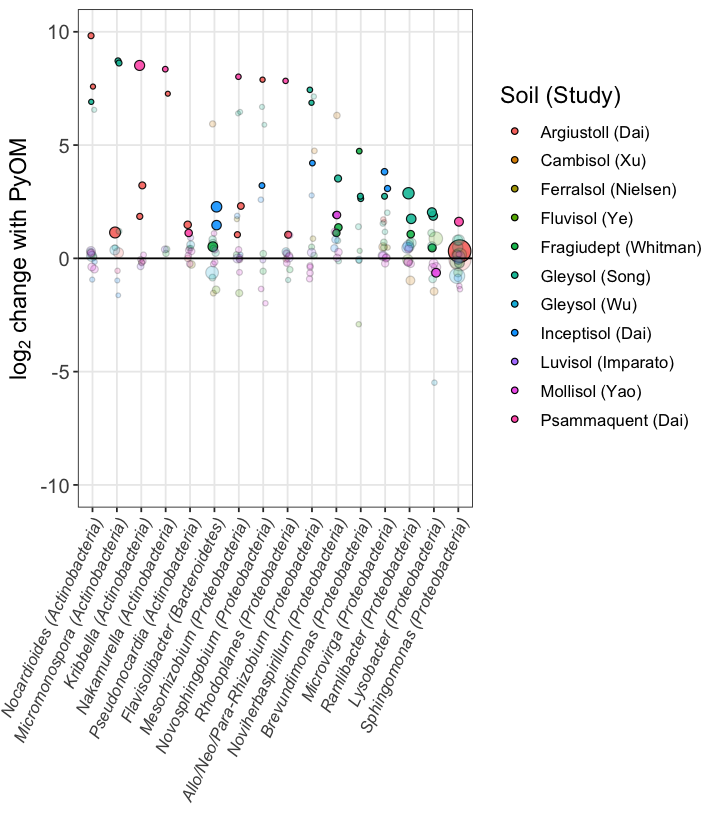

In [54]:
options(repr.plot.width=6, repr.plot.height=7)

p = ggplot(d, aes(x = OTUName, y = l2FC, fill=SoilTypeName, size = RelAbund, alpha=Sig))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being phylum, relative size proportional to mean abundance, and alpha (transparency) based on
# whether or not the adjusted p value is significant.
p = p + geom_jitter(shape=21, width=0.1) # Using shape=21 to get the option that has an outline and a fill colour
p = p + theme_bw()
# sets a theme - adjusts a bunch of aesthetics at once
p = p + theme(strip.text.x = element_text(size = 14),
              strip.text.y = element_text(size = 14),
              axis.text.x = element_text(size = 10, angle = 65, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 14),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 10),
              #legend.position = "none",
              strip.background = element_blank()
              ) + 
        guides(size=FALSE, alpha=FALSE, fill=guide_legend(title="Soil (Study)"))
p = p + scale_alpha_manual(values=c(0.2,0.9))
# sets a bunch of visual paramters for the legend (none) and other text
p = p + labs(x = "")
# sets the label for the x axis.
p = p + labs(y = expression(paste("", log[2]," change with PyOM",sep="")))
# sets the label for the y axes.
p = p + theme(panel.grid.minor = element_blank())
# Gets rid of the default gridlines
p = p + geom_hline(yintercept=0)
p = p + ylim(c(-10,10))
#p = p + facet_wrap(~Phylum, scales="free",ncol=4)

p

## And then considering the family level

In [112]:
ps = readRDS("ps.glom.family.ps")
# Import ps object
ps = subset_samples(ps, Incubation_Time_Weeks != 0)
ps = subset_samples(ps, PyOM != "OM")
# Remove the initial measurements and the OM only treatments

sample_data(ps)$SoilTypeName = paste(sample_data(ps)$SoilType," (",sample_data(ps)$Author,")",sep="")
# Create a variable that separates by studies / soil type

sample_data(ps)$Feedstock_Category = ifelse(sample_data(ps)$Feedstock %in% c('commercial cornstock powder', 'corn stover', 'corncob',"Corn Straw"), "Corn",
                                   ifelse(sample_data(ps)$Feedstock %in% c('wheat straw','winter wheat'),"Wheat",
                                          ifelse(sample_data(ps)$Feedstock %in% c('Jarrah wood'),"Eucalyptus",
                                                 ifelse(sample_data(ps)$Feedstock =='Manure', "Manure","Unknown"))))
# Rename the feedstocks for consistency

sample_data(ps)$CharType = ifelse(sample_data(ps)$PyOM=="PyOM",paste(sample_data(ps)$Feedstock_Category,sample_data(ps)$PyOM.Temp,sep=""),"Control")
#sample_data(ps)$CharType = ifelse(sample_data(ps)$PyOM=="PyOM",sample_data(ps)$Feedstock_Category,"Control")
levels(as.factor(sample_data(ps)$CharType))
# These are all the PyOM samples we will want to test.

ps = subset_samples(ps, !(Author == "Song" & SoilType == "Gleysol" & Incubation_Time_Weeks == 24))
# Removing one set of samples that we know doesn't have a control

ps.list = list()

Studies = levels(as.factor(sample_data(ps)$SoilTypeName))
n = 1
for (i in 1:length(Studies)) {
  STN = Studies[i]
  ps.study = subset_samples(ps, sample_data(ps)$SoilTypeName==STN)
  Dates = levels(as.factor(sample_data(ps.study)$Incubation_Time_Weeks))
  for (j in 1:length(Dates)){
    DATE = Dates[j]
    ps.study.date = subset_samples(ps.study, sample_data(ps.study)$Incubation_Time_Weeks==DATE)
    Chars = levels(as.factor(sample_data(ps.study)$CharType))
    for (k in 2:length(Chars)){
      CHAR = Chars[k]
      #print(paste(CHAR,DATE,STN))
      ps.study.date.char = subset_samples(ps.study.date,(sample_data(ps.study.date)$CharType==CHAR | sample_data(ps.study.date)$CharType=="Control"))
      ps.list[n]=ps.study.date.char
      n=n+1
    }
  }
}
# Creating a series of ps objects for each combination of char types and dates. (Rates not considered separately)
# This set is for each dataset individually after the glom (genus-level)

[1] "Control"       "Corn"          "Corn350"       "Corn450"      
 [5] "Corn500"       "Eucalyptus600" "Manure300"     "Manure550"    
 [9] "Manure700"     "Unknown550"    "Wheat300"      "Wheat600"     
[13] "Wheat750"

Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.

In [113]:
ps.list.output.fam = list()

#for (i in c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20)){
for (i in 1:length(ps.list)){
  ps = ps.list[[i]]
  # Getting the ps object
  comparison_test=ps.runner(ps)
  # Run the analysis
  ps.list.output.fam[[i]]=comparison_test
}
# Running the function on all ps objects

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are ch

In [114]:
#saveRDS(ps.list.output.fam,"ps.list.output.fam")
ps.list.output.fam = readRDS("ps.list.output.fam")

In [115]:
# Make one giant dataframe of everything
DA = rbind(ps.list.output.fam[[1]],ps.list.output.fam[[2]],ps.list.output.fam[[3]],ps.list.output.fam[[4]],ps.list.output.fam[[5]],
          ps.list.output.fam[[6]],ps.list.output.fam[[7]],ps.list.output.fam[[8]],ps.list.output.fam[[9]],ps.list.output.fam[[10]],
          ps.list.output.fam[[11]],ps.list.output.fam[[12]],ps.list.output.fam[[13]],ps.list.output.fam[[14]],ps.list.output.fam[[15]],
          ps.list.output.fam[[16]],ps.list.output.fam[[17]],ps.list.output.fam[[18]],ps.list.output.fam[[19]],ps.list.output.fam[[20]],
          ps.list.output.fam[[21]])

In [116]:
DA = DA %>%
    group_by(SoilTypeName,CharType,Incubation_Time_Weeks)%>%
    mutate(RelAbund = baseMean/sum(baseMean))%>%
    group_by()
# Add a rough relative abundance column (for all samples in dataset)

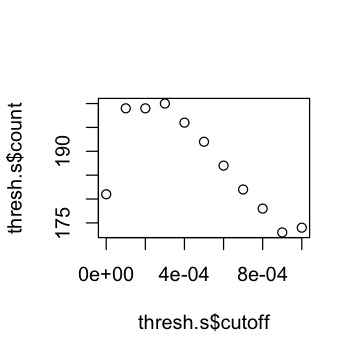

In [117]:
### We need to adjust for allll of these multiple comparisons together

options(repr.plot.width=3, repr.plot.height=3)

# Independent filtering
threshold = function (thresh){
    dplyr::summarize(dplyr::mutate(dplyr::filter(DA, RelAbund >= thresh), padj = p.adjust(pvalue,"BH")),cutoff=thresh, count=sum(padj<=0.05, na.rm = TRUE))
}

range = seq(0,0.001,0.0001)
# Creates a range of numbers we are interested in for adjusted p values

thresh.s = plyr::ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here at the peak of the graph

In [118]:
cutoff = 0.0003
pval = 0.05

DA = dplyr::filter(DA,RelAbund>=cutoff)
# Filter out low-abundance OTUs
DA = dplyr::mutate(DA, padj = p.adjust(pvalue,"BH"))
# Adjust remaining pvalues for multiple comparisons across the entire dataset
DA = dplyr::mutate(DA, Sig = ifelse(padj<pval,"significant","not significant"))
# Add a column designating significance

d = DA

In [119]:
d = d %>%
    dplyr::filter(!is.na(Sig))
# Remove untested taxa

cutoff = 2
# Minimum number of studies in which a genus must be significant to plot

SigPhy = d %>%
    filter(padj<pval)%>%
    filter(l2FC>0)%>%
    group_by(SoilTypeName,Family)%>%
    summarize(TotalResp = n())%>%
    group_by(Family)%>%
    summarize(TotalStudies=n())%>%
    arrange(-TotalStudies)%>%
    filter(TotalStudies >= cutoff)
# Makes a data frame of the total soil types/studies in which each taxon was significant positive responder

d = d %>%
    filter(Family %in% SigPhy$Family)
# Keep only genera that were significant in at least one study

In [120]:
cutoff = 4
# Minimum number of studies a genus must be present in to plot

nStudies = d %>%
    group_by(Family,SoilTypeName)%>%
    summarize(N=n())%>%
    arrange(-N)%>%
    group_by(Family)%>%
    summarize(NStudies=n())%>%
    arrange(-NStudies)%>%
    filter(NStudies>=cutoff)
#nStudies in which it is present

dim(d)
d = d %>%
    filter(Family %in% nStudies$Family)
# Filter so we only look at genera that include at least one significant responder
# and that are also present in at least [cutoff] studies

dim(d)

[1] 275  18

[1] 275  18

In [121]:
OTUNameOrder = d %>%
    group_by(Phylum,Family)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Phylum,-Max)
OTUNameOrder=paste(OTUNameOrder$Family)
d$Family = factor(d$Family,levels=OTUNameOrder)

GenusOrder = d %>%
    group_by(Phylum,Family)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Phylum,-Max)
GenusOrder=paste(GenusOrder$Family)
d$Family = factor(d$Family,levels=GenusOrder)

OTUNameClassOrder = d %>%
    group_by(OTUNameClass)%>%
    summarize(Max = max(l2FC))%>%
    arrange(-Max)
OTUNameClassOrder=paste(OTUNameClassOrder$OTUNameClass)
d$OTUNameClass = factor(d$OTUNameClass,levels=OTUNameClassOrder)

OTUNameOrderOrder = d %>%
    group_by(Order,OTUNameOrder)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Order,-Max)
OTUNameOrderOrder=paste(OTUNameOrderOrder$OTUNameOrder)
d$OTUNameOrder = factor(d$OTUNameOrder,levels=OTUNameOrderOrder)


ERROR: Error: Column `OTUNameClass` is unknown


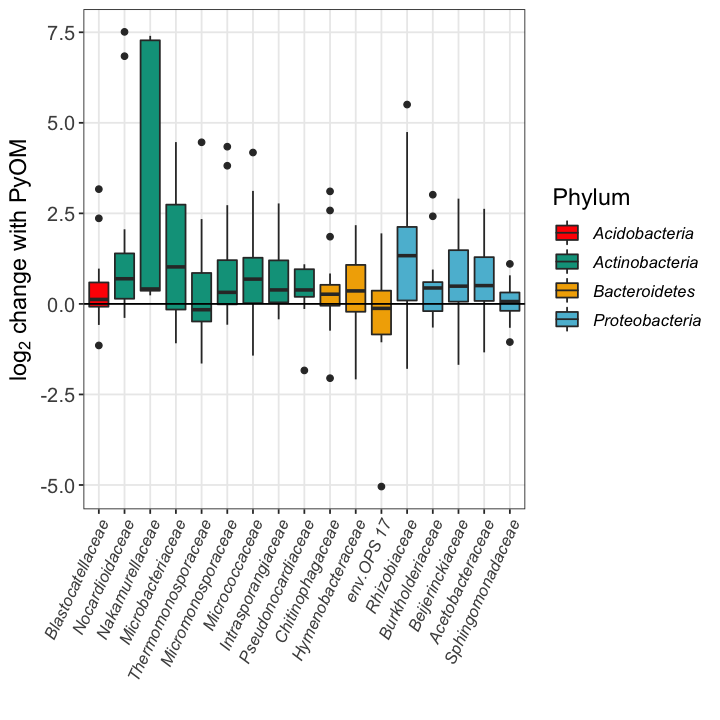

In [122]:
options(repr.plot.width=6, repr.plot.height=6)

palette = c(wes_palette("Darjeeling1"),"grey","white")

p = ggplot(d, aes(x = Family, y = l2FC, fill=Phylum))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being phylum, relative size proportional to mean abundance, and alpha (transparency) based on
# whether or not the adjusted p value is significant.
p = p + geom_boxplot() # Using shape=21 to get the option that has an outline and a fill colour
p = p + theme_bw()
# sets a theme - adjusts a bunch of aesthetics at once
p = p + theme(strip.text.x = element_text(size = 14),
              strip.text.y = element_text(size = 14),
              axis.text.x = element_text(size = 10, angle = 65, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 14),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 10, face="italic"),
              #legend.position = "none",
              strip.background = element_blank()
              ) + 
        guides(size=FALSE, alpha=FALSE, fill=guide_legend(title="Phylum"))
p = p + scale_alpha_manual(values=c(0.2,0.9))
p = p + scale_fill_manual(values=palette[c(1,2,3,5)])
# sets a bunch of visual paramters for the legend (none) and other text
p = p + labs(x = "")
# sets the label for the x axis.
p = p + labs(y = expression(paste("", log[2]," change with PyOM",sep="")))
# sets the label for the y axes.
p = p + theme(panel.grid.minor = element_blank())
# Gets rid of the default gridlines
p = p + geom_hline(yintercept=0)

p

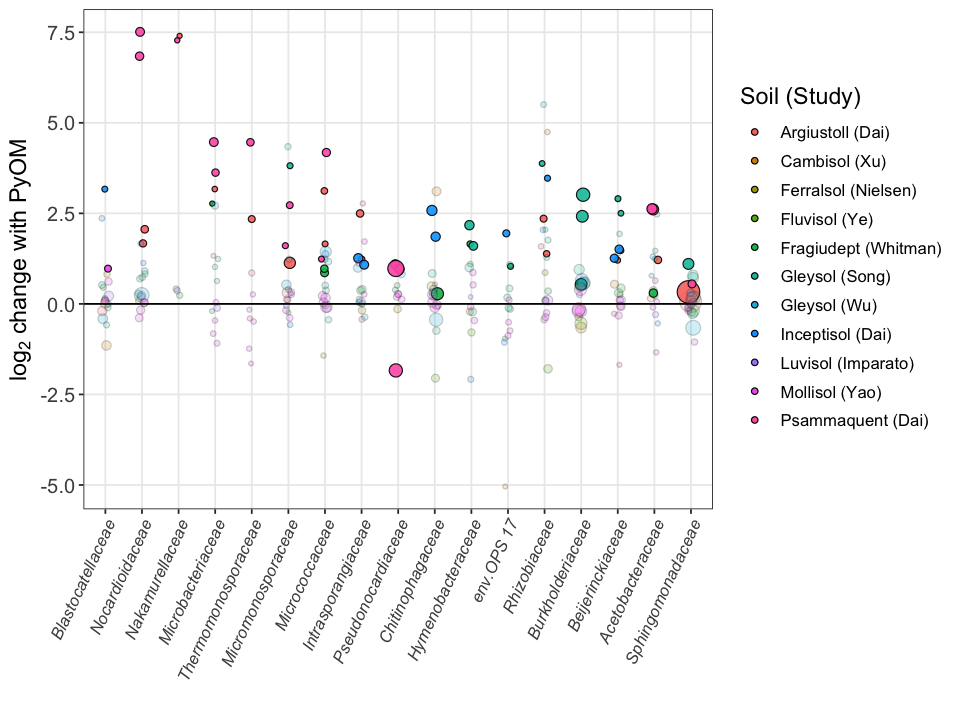

In [123]:
options(repr.plot.width=8, repr.plot.height=6)

p = ggplot(d, aes(x = Family, y = l2FC, fill=SoilTypeName, size = RelAbund, alpha=Sig))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being phylum, relative size proportional to mean abundance, and alpha (transparency) based on
# whether or not the adjusted p value is significant.
p = p + geom_jitter(shape=21, width=0.1) # Using shape=21 to get the option that has an outline and a fill colour
p = p + theme_bw()
# sets a theme - adjusts a bunch of aesthetics at once
p = p + theme(strip.text.x = element_text(size = 14),
              strip.text.y = element_text(size = 14),
              axis.text.x = element_text(size = 10, angle = 65, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 14),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 10),
              #legend.position = "none",
              strip.background = element_blank()
              ) + 
        guides(size=FALSE, alpha=FALSE, fill=guide_legend(title="Soil (Study)"))
p = p + scale_alpha_manual(values=c(0.2,0.9))
# sets a bunch of visual paramters for the legend (none) and other text
p = p + labs(x = "")
# sets the label for the x axis.
p = p + labs(y = expression(paste("", log[2]," change with PyOM",sep="")))
# sets the label for the y axes.
p = p + theme(panel.grid.minor = element_blank())
# Gets rid of the default gridlines
p = p + geom_hline(yintercept=0)
#p = p + facet_wrap(~Phylum, scales="free",ncol=4)

p

## And finally, the order level

In [124]:
ps = readRDS("ps.glom.order.ps")
# Import ps object
ps = subset_samples(ps, Incubation_Time_Weeks != 0)
ps = subset_samples(ps, PyOM != "OM")
# Remove the initial measurements and the OM only treatments

sample_data(ps)$SoilTypeName = paste(sample_data(ps)$SoilType," (",sample_data(ps)$Author,")",sep="")
# Create a variable that separates by studies / soil type

sample_data(ps)$Feedstock_Category = ifelse(sample_data(ps)$Feedstock %in% c('commercial cornstock powder', 'corn stover', 'corncob', "Corn Straw"), "Corn",
                                   ifelse(sample_data(ps)$Feedstock %in% c('wheat straw','winter wheat'),"Wheat",
                                          ifelse(sample_data(ps)$Feedstock %in% c('Jarrah wood'),"Eucalyptus",
                                                 ifelse(sample_data(ps)$Feedstock =='Manure', "Manure","Unknown"))))
# Rename the feedstocks for consistency

sample_data(ps)$CharType = ifelse(sample_data(ps)$PyOM=="PyOM",paste(sample_data(ps)$Feedstock_Category,sample_data(ps)$PyOM.Temp,sep=""),"Control")
#sample_data(ps)$CharType = ifelse(sample_data(ps)$PyOM=="PyOM",sample_data(ps)$Feedstock_Category,"Control")
levels(as.factor(sample_data(ps)$CharType))
# These are all the PyOM samples we will want to test.

ps = subset_samples(ps, !(Author == "Song" & SoilType == "Gleysol" & Incubation_Time_Weeks == 24))
# Removing one set of samples that we know doesn't have a control

ps.list = list()

Studies = levels(as.factor(sample_data(ps)$SoilTypeName))
n = 1
for (i in 1:length(Studies)) {
  STN = Studies[i]
  ps.study = subset_samples(ps, sample_data(ps)$SoilTypeName==STN)
  Dates = levels(as.factor(sample_data(ps.study)$Incubation_Time_Weeks))
  for (j in 1:length(Dates)){
    DATE = Dates[j]
    ps.study.date = subset_samples(ps.study, sample_data(ps.study)$Incubation_Time_Weeks==DATE)
    Chars = levels(as.factor(sample_data(ps.study)$CharType))
    for (k in 2:length(Chars)){
      CHAR = Chars[k]
      #print(paste(CHAR,DATE,STN))
      ps.study.date.char = subset_samples(ps.study.date,(sample_data(ps.study.date)$CharType==CHAR | sample_data(ps.study.date)$CharType=="Control"))
      ps.list[n]=ps.study.date.char
      n=n+1
    }
  }
}
# Creating a series of ps objects for each combination of char types and dates. (Rates not considered separately)
# This set is for each dataset individually after the glom (genus-level)

[1] "Control"       "Corn"          "Corn350"       "Corn450"      
 [5] "Corn500"       "Eucalyptus600" "Manure300"     "Manure550"    
 [9] "Manure700"     "Unknown550"    "Wheat300"      "Wheat600"     
[13] "Wheat750"

Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.study.date.char):
“implicit list embedding of S4 objects is deprecated”Warning message in `[<-`(`*tmp*`, n, value = ps.

In [125]:
ps.list.output.order = list()

#for (i in c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20)){
for (i in 1:length(ps.list)){
  ps = ps.list[[i]]
  # Getting the ps object
  comparison_test=ps.runner(ps)
  # Run the analysis
  ps.list.output.order[[i]]=comparison_test
}
# Running the function on all ps objects

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are ch

In [126]:
# Make one giant dataframe of everything
DA = rbind(ps.list.output.order[[1]],ps.list.output.order[[2]],ps.list.output.order[[3]],ps.list.output.order[[4]],ps.list.output.order[[5]],
          ps.list.output.order[[6]],ps.list.output.order[[7]],ps.list.output.order[[8]],ps.list.output.order[[9]],ps.list.output.order[[10]],
          ps.list.output.order[[11]],ps.list.output.order[[12]],ps.list.output.order[[13]],ps.list.output.order[[14]],ps.list.output.order[[15]],
          ps.list.output.order[[16]],ps.list.output.order[[17]],ps.list.output.order[[18]],ps.list.output.order[[19]],ps.list.output.order[[20]],
          ps.list.output.order[[21]])

DA = DA %>%
    group_by(SoilTypeName,CharType,Incubation_Time_Weeks)%>%
    mutate(RelAbund = baseMean/sum(baseMean))%>%
    group_by()
# Add a rough relative abundance column (for all samples in dataset)

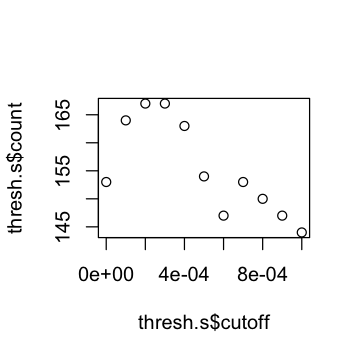

In [135]:
### We need to adjust for allll of these multiple comparisons together

options(repr.plot.width=3, repr.plot.height=3)

# Independent filtering
threshold = function (thresh){
    dplyr::summarize(dplyr::mutate(dplyr::filter(DA, RelAbund >= thresh), padj = p.adjust(pvalue,"BH")),cutoff=thresh, count=sum(padj<=0.05, na.rm = TRUE))
}

range = seq(0,0.001,0.0001)
# Creates a range of numbers we are interested in for adjusted p values

thresh.s = plyr::ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here at the peak of the graph (here, ~1.5)

In [127]:
cutoff = 0.0003
pval = 0.05

DA = dplyr::filter(DA,RelAbund>=cutoff)
# Filter out low-abundance OTUs
DA = dplyr::mutate(DA, padj = p.adjust(pvalue,"BH"))
# Adjust remaining pvalues for multiple comparisons across the entire dataset
DA = dplyr::mutate(DA, Sig = ifelse(padj<pval,"significant","not significant"))
# Add a column designating significance

d = DA

In [128]:
d = d %>%
    dplyr::filter(!is.na(Sig))
# Remove untested taxa

cutoff = 2
# Minimum number of studies in which a genus must be significant to plot

SigPhy = d %>%
    filter(padj<pval)%>%
    filter(l2FC>0)%>%
    group_by(SoilTypeName,Order)%>%
    summarize(TotalResp = n())%>%
    group_by(Order)%>%
    summarize(TotalStudies=n())%>%
    arrange(-TotalStudies)%>%
    filter(TotalStudies >= cutoff)
# Makes a data frame of the total soil types/studies in which each taxon was significant positive responder

d = d %>%
    filter(Order %in% SigPhy$Order)
# Keep only genera that were significant in at least one study

d$OTUName = paste(d$Order," (", d$Phylum,")",sep="")
d$OTUNameClass = paste(d$Order," (", substr(d$Class,1,5),")",sep="")
d$OTUNameOrder = paste(d$Order," (", d$Order,")",sep="")
# Just some category naming for graphing

In [129]:
cutoff = 4
# Minimum number of studies a genus must be present in to plot

nStudies = d %>%
    group_by(Order,SoilTypeName)%>%
    summarize(N=n())%>%
    arrange(-N)%>%
    group_by(Order)%>%
    summarize(NStudies=n())%>%
    arrange(-NStudies)%>%
    filter(NStudies>=cutoff)
#nStudies in which it is present

dim(d)
d = d %>%
    filter(Order %in% nStudies$Order)
# Filter so we only look at genera that include at least one significant responder
# and that are also present in at least [cutoff] studies

dim(d)

[1] 196  21

[1] 196  21

In [130]:
OTUNameOrder = d %>%
    group_by(Phylum,Order)%>%
    summarize(Max = max(l2FC))%>%
    arrange(Phylum,-Max)
OTUNameOrder=paste(OTUNameOrder$Order)
d$Order = factor(d$Order,levels=OTUNameOrder)


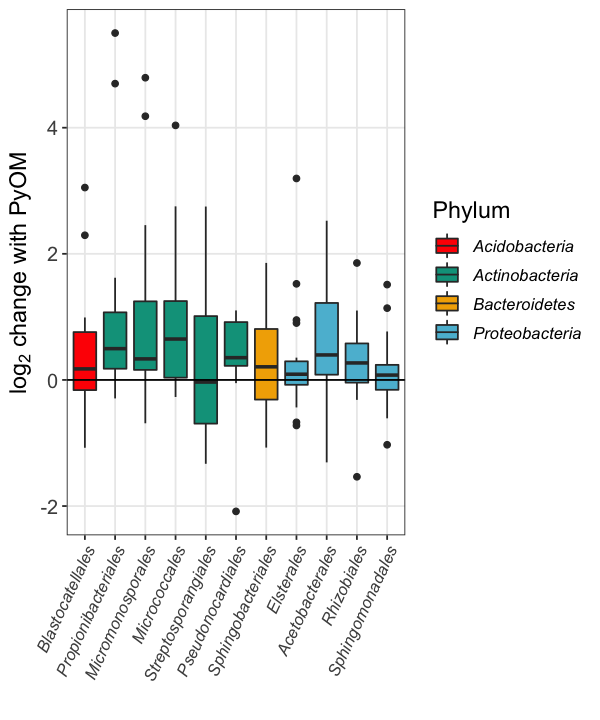

In [132]:
options(repr.plot.width=5, repr.plot.height=6)

palette = c(wes_palette("Darjeeling1"),"grey","white")

p = ggplot(d, aes(x = Order, y = l2FC, fill=Phylum))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being phylum, relative size proportional to mean abundance, and alpha (transparency) based on
# whether or not the adjusted p value is significant.
p = p + geom_boxplot() # Using shape=21 to get the option that has an outline and a fill colour
p = p + theme_bw()
# sets a theme - adjusts a bunch of aesthetics at once
p = p + theme(strip.text.x = element_text(size = 14),
              strip.text.y = element_text(size = 14),
              axis.text.x = element_text(size = 10, angle = 65, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 14),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 10, face="italic"),
              #legend.position = "none",
              strip.background = element_blank()
              ) + 
        guides(size=FALSE, alpha=FALSE, fill=guide_legend(title="Phylum"))
p = p + scale_alpha_manual(values=c(0.2,0.9))
p = p + scale_fill_manual(values=palette[c(1,2,3,5)])
# sets a bunch of visual paramters for the legend (none) and other text
p = p + labs(x = "")
# sets the label for the x axis.
p = p + labs(y = expression(paste("", log[2]," change with PyOM",sep="")))
# sets the label for the y axes.
p = p + theme(panel.grid.minor = element_blank())
# Gets rid of the default gridlines
p = p + geom_hline(yintercept=0)

p

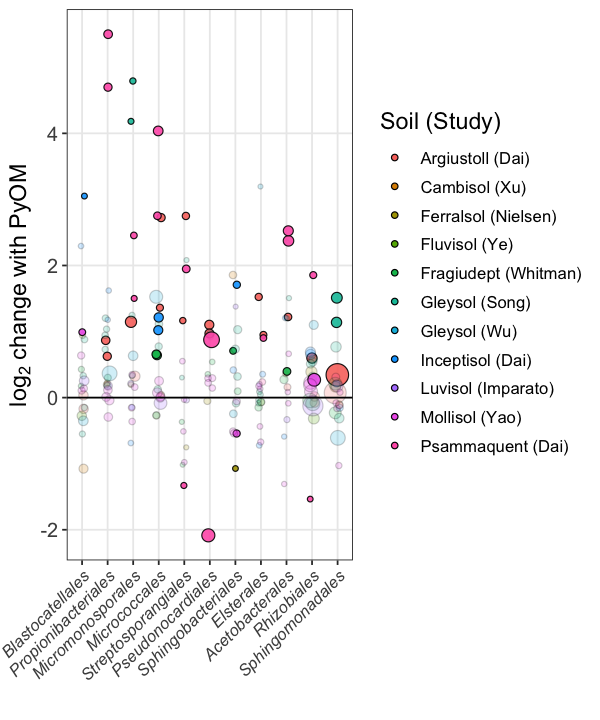

In [133]:
options(repr.plot.width=5, repr.plot.height=6)

p = ggplot(d, aes(x = Order, y = l2FC, fill=SoilTypeName, size = RelAbund, alpha=Sig))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being phylum, relative size proportional to mean abundance, and alpha (transparency) based on
# whether or not the adjusted p value is significant.
p = p + geom_jitter(shape=21, width=0.1) # Using shape=21 to get the option that has an outline and a fill colour
p = p + theme_bw()
# sets a theme - adjusts a bunch of aesthetics at once
p = p + theme(strip.text.x = element_text(size = 14),
              strip.text.y = element_text(size = 14),
              axis.text.x = element_text(size = 10, angle = 45, hjust = 1, vjust = 1, face="italic"),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 14),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 10),
              #legend.position = "none",
              strip.background = element_blank()
              ) + 
        guides(size=FALSE, alpha=FALSE, fill=guide_legend(title="Soil (Study)"))
p = p + scale_alpha_manual(values=c(0.2,0.9))
# sets a bunch of visual paramters for the legend (none) and other text
p = p + labs(x = "")
# sets the label for the x axis.
p = p + labs(y = expression(paste("", log[2]," change with PyOM",sep="")))
# sets the label for the y axes.
p = p + theme(panel.grid.minor = element_blank())
# Gets rid of the default gridlines
p = p + geom_hline(yintercept=0)
#p = p + facet_wrap(~Phylum, scales="free",ncol=4)

p

## Testing various effects

In [191]:
# Want to make sure d is appropriate d (OTU-level, not filtered by significance)

substrRight <- function(x, n){
  substr(x, nchar(x)-n+1, nchar(x))
}
# Function to extract right n characters from a string - https://stackoverflow.com/questions/7963898/extracting-the-last-n-characters-from-a-string-in-r
d$Temp = substrRight(as.character(d$CharType),3)
d$Temp[d$Temp=="orn"] = "Unknown"
d$Temp = as.factor(d$Temp)
# For the unknown corn feedstock

d.Temp = d %>%
    filter(SoilTypeName %in% c("Argiustoll (Dai)","Psammaquent (Dai)","Gleysol (Song)"))

d.Temp.Song = d.Temp %>%
    filter(SoilTypeName == "Gleysol (Song)")
d.Temp.Song = merge(d.Temp.Song[d.Temp.Song$Temp==300,],d.Temp.Song[d.Temp.Song$Temp==600,],by="OTU")%>%
    filter(Incubation_Time_Weeks.x==Incubation_Time_Weeks.y)%>%
    filter(Sig.x=="significant" | Sig.y=="significant" )

d.Temp.ADai = d.Temp %>%
    filter(SoilTypeName == "Argiustoll (Dai)")
d.Temp.ADai = merge(d.Temp.ADai[d.Temp.ADai$Temp==300,],d.Temp.ADai[d.Temp.ADai$Temp==700,],by="OTU")%>%
    filter(Sig.x=="significant" | Sig.y=="significant" )

d.Temp.PDai = d.Temp %>%
    filter(SoilTypeName == "Psammaquent (Dai)")
d.Temp.PDai = merge(d.Temp.PDai[d.Temp.PDai$Temp==300,],d.Temp.PDai[d.Temp.PDai$Temp==700,],by="OTU")%>%
    filter(Sig.x=="significant" | Sig.y=="significant" )

t.test(d.Temp.Song$l2FC.y,d.Temp.Song$l2FC.x, paired=TRUE)
t.test(d.Temp.ADai$l2FC.y,d.Temp.ADai$l2FC.x, paired=TRUE)
t.test(d.Temp.PDai$l2FC.y,d.Temp.PDai$l2FC.x, paired=TRUE)


	Paired t-test

data:  d.Temp.Song$l2FC.y and d.Temp.Song$l2FC.x
t = -1.8992, df = 84, p-value = 0.06097
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.45788242  0.03351388
sample estimates:
mean of the differences 
             -0.7121843 



	Paired t-test

data:  d.Temp.ADai$l2FC.y and d.Temp.ADai$l2FC.x
t = 1.3637, df = 105, p-value = 0.1756
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1597852  0.8637618
sample estimates:
mean of the differences 
              0.3519883 



	Paired t-test

data:  d.Temp.PDai$l2FC.y and d.Temp.PDai$l2FC.x
t = 8.352, df = 175, p-value = 1.987e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.029482 3.285417
sample estimates:
mean of the differences 
                2.65745 


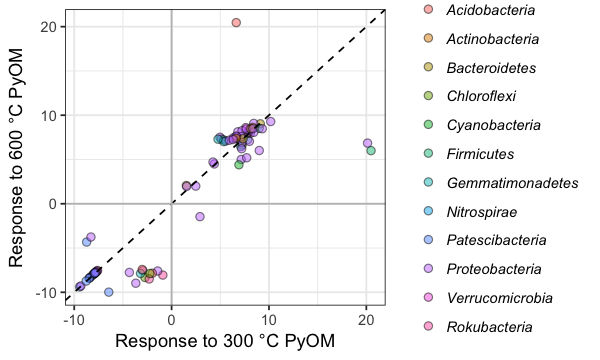

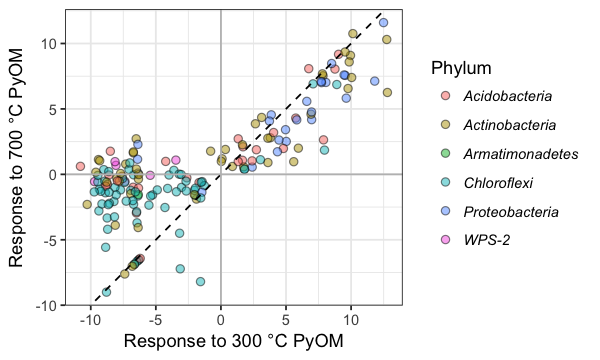


Call:
lm(formula = (l2FC.y) ~ l2FC.x, data = d.Temp.Song)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.7829   0.1244   0.3364   1.4237  14.7728 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.59316    0.39181  -1.514    0.134    
l2FC.x       0.94571    0.05209  18.155   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.455 on 83 degrees of freedom
Multiple R-squared:  0.7988,	Adjusted R-squared:  0.7964 
F-statistic: 329.6 on 1 and 83 DF,  p-value: < 2.2e-16



Call:
lm(formula = (l2FC.y) ~ l2FC.x, data = d.Temp.PDai)

Residuals:
   Min     1Q Median     3Q    Max 
-9.060 -1.442  0.162  1.662  4.374 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.60141    0.19088   8.389 1.63e-14 ***
l2FC.x       0.47154    0.02794  16.876  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.422 on 174 degrees of freedom
Multiple R-squared:  0.6208,	Adjusted R-squared:  0.6186 
F-statistic: 284.8 on 1 and 174 DF,  p-value: < 2.2e-16



Call:
lm(formula = (l2FC.y) ~ l2FC.x, data = d.Temp.ADai)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.4271 -1.0828 -0.2161  0.8548  4.8078 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.62793    0.20119   3.121  0.00233 ** 
l2FC.x       0.64568    0.04137  15.607  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.045 on 104 degrees of freedom
Multiple R-squared:  0.7008,	Adjusted R-squared:  0.6979 
F-statistic: 243.6 on 1 and 104 DF,  p-value: < 2.2e-16


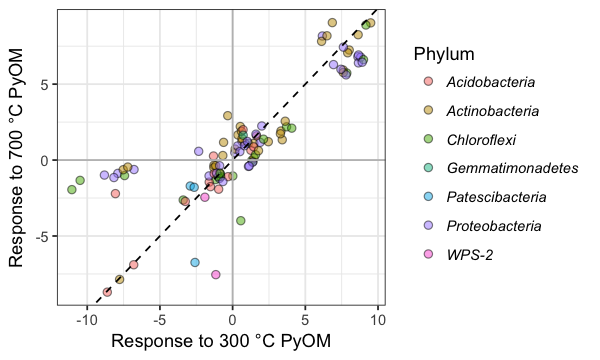

In [192]:
options(repr.plot.width=5, repr.plot.height=3)
# Want to find OTUs with two temperature values
p = ggplot(d.Temp.Song,aes(x=l2FC.x,y=l2FC.y,fill=Phylum.x))
p = p + geom_point(shape=21, size=2, alpha=0.5) + geom_abline(slope=1,intercept=0,linetype=2)+ geom_hline(yintercept=0,linetype=1,color="grey") + geom_vline(xintercept=0,linetype=1,color="grey")
p = p + theme_bw() + theme(legend.text = element_text(face="italic"))
p = p + xlab("Response to 300 °C PyOM") + ylab("Response to 600 °C PyOM")
p = p + guides(fill=guide_legend(title="Phylum"))
p

p = ggplot(d.Temp.PDai,aes(x=l2FC.x,y=l2FC.y,fill=Phylum.x))
p = p + geom_point(shape=21, size=2, alpha=0.5) + geom_abline(slope=1,intercept=0,linetype=2)+ geom_hline(yintercept=0,linetype=1,color="grey") + geom_vline(xintercept=0,linetype=1,color="grey")
p = p + theme_bw() + theme(legend.text = element_text(face="italic"))
p = p + xlab("Response to 300 °C PyOM") + ylab("Response to 700 °C PyOM")
p = p + guides(fill=guide_legend(title="Phylum"))
p

p = ggplot(d.Temp.ADai,aes(x=l2FC.x,y=l2FC.y,fill=Phylum.x))
p = p + geom_point(shape=21, size=2, alpha=0.5) + geom_abline(slope=1,intercept=0,linetype=2)+ geom_hline(yintercept=0,linetype=1,color="grey") + geom_vline(xintercept=0,linetype=1,color="grey")
p = p + theme_bw() + theme(legend.text = element_text(face="italic"))
p = p + xlab("Response to 300 °C PyOM") + ylab("Response to 700 °C PyOM")
p = p + guides(fill=guide_legend(title="Phylum"))
p

summary(lm((l2FC.y)~l2FC.x,d.Temp.Song))
summary(lm((l2FC.y)~l2FC.x,d.Temp.PDai))
summary(lm((l2FC.y)~l2FC.x,d.Temp.ADai))

In [193]:
Times = d %>%
    group_by(SoilTypeName, Incubation_Time_Weeks)%>%
    summarize(n())
Times

SoilTypeName,Incubation_Time_Weeks,n()
Gleysol (Wu),8.5,236
Luvisol (Imparato),13,731
Mollisol (Yao),104,1064
Mollisol (Yao),112,1145
Mollisol (Yao),121,1106
Mollisol (Yao),128,1050
Inceptisol (Dai),21,3013
Argiustoll (Dai),34,938
Psammaquent (Dai),34,802
Gleysol (Song),12,2883


In [194]:
d.Time = d %>%
    filter(SoilTypeName %in% c("Fragiudept (Whitman)","Mollisol (Yao)","Gleysol (Song)"))

d.Time.Whitman = d.Time %>%
    filter(SoilTypeName == "Fragiudept (Whitman)")
d.Time.Whitman = merge(d.Time.Whitman[d.Time.Whitman$Incubation_Time_Weeks==1.5,],d.Time.Whitman[d.Time.Whitman$Incubation_Time_Weeks==12,],by="OTU")%>%filter(Sig.x=="significant"|Sig.y=="significant")

d.Time.Yao = d.Time %>%
    filter(SoilTypeName == "Mollisol (Yao)")
d.Time.Yao = merge(d.Time.Yao[d.Time.Yao$Incubation_Time_Weeks==104,],d.Time.Yao[d.Time.Yao$Incubation_Time_Weeks==128,],by="OTU")%>%filter(Sig.x=="significant"|Sig.y=="significant")
# Using first and last timepoints

d.Time.Song = d.Time %>%
    filter(SoilTypeName == "Gleysol (Song)")
d.Time.Song = merge(d.Time.Song[d.Time.Song$Incubation_Time_Weeks==4,],d.Time.Song[d.Time.Song$Incubation_Time_Weeks==12,],by="OTU")%>%
    filter(CharType.x==CharType.y)%>%filter(Sig.x=="significant"|Sig.y=="significant")

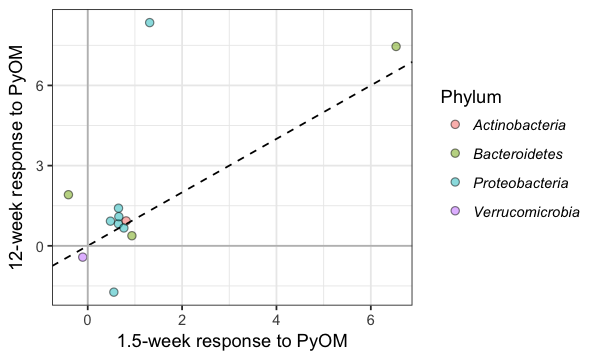

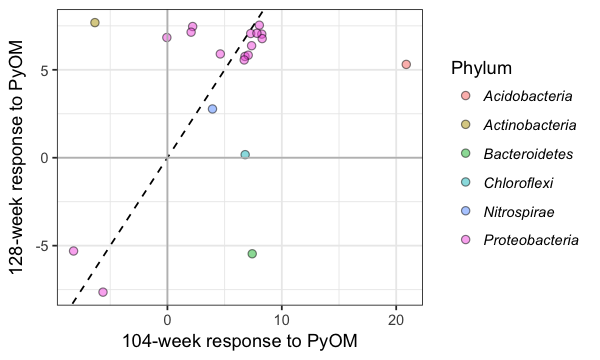


Call:
lm(formula = (l2FC.y - l2FC.x) ~ l2FC.x, data = d.Time.Whitman)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9702 -0.8360 -0.4943 -0.1608  6.2631 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.6188     0.8015   0.772    0.458
l2FC.x        0.1181     0.3984   0.296    0.773

Residual standard error: 2.351 on 10 degrees of freedom
Multiple R-squared:  0.008706,	Adjusted R-squared:  -0.09042 
F-statistic: 0.08782 on 1 and 10 DF,  p-value: 0.773



Call:
lm(formula = (l2FC.y - l2FC.x) ~ l2FC.x, data = d.Time.Yao)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.420  -1.771   1.497   2.208   6.695 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.8185     1.2818   2.199  0.04121 *  
l2FC.x       -0.7114     0.1633  -4.357  0.00038 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.557 on 18 degrees of freedom
Multiple R-squared:  0.5133,	Adjusted R-squared:  0.4863 
F-statistic: 18.98 on 1 and 18 DF,  p-value: 0.0003798



Call:
lm(formula = (l2FC.y - l2FC.x) ~ l2FC.x, data = d.Time.Song)

Residuals:
   Min     1Q Median     3Q    Max 
-7.971 -2.992 -1.034  2.867 20.167 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.21711    0.38268   0.567    0.572    
l2FC.x      -0.69683    0.04924 -14.153   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.121 on 117 degrees of freedom
Multiple R-squared:  0.6313,	Adjusted R-squared:  0.6281 
F-statistic: 200.3 on 1 and 117 DF,  p-value: < 2.2e-16



Call:
lm(formula = (l2FC.y) ~ l2FC.x, data = d.Time.Whitman)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9702 -0.8360 -0.4943 -0.1608  6.2631 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   0.6188     0.8015   0.772   0.4579  
l2FC.x        1.1181     0.3984   2.806   0.0186 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.351 on 10 degrees of freedom
Multiple R-squared:  0.4406,	Adjusted R-squared:  0.3846 
F-statistic: 7.875 on 1 and 10 DF,  p-value: 0.01859



Call:
lm(formula = (l2FC.y) ~ l2FC.x, data = d.Time.Yao)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.420  -1.771   1.497   2.208   6.695 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   2.8185     1.2818   2.199   0.0412 *
l2FC.x        0.2886     0.1633   1.768   0.0940 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.557 on 18 degrees of freedom
Multiple R-squared:  0.1479,	Adjusted R-squared:  0.1006 
F-statistic: 3.125 on 1 and 18 DF,  p-value: 0.09405



Call:
lm(formula = (l2FC.y) ~ l2FC.x, data = d.Time.Song)

Residuals:
   Min     1Q Median     3Q    Max 
-7.971 -2.992 -1.034  2.867 20.167 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.21711    0.38268   0.567    0.572    
l2FC.x       0.30317    0.04924   6.158 1.07e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.121 on 117 degrees of freedom
Multiple R-squared:  0.2448,	Adjusted R-squared:  0.2383 
F-statistic: 37.92 on 1 and 117 DF,  p-value: 1.072e-08


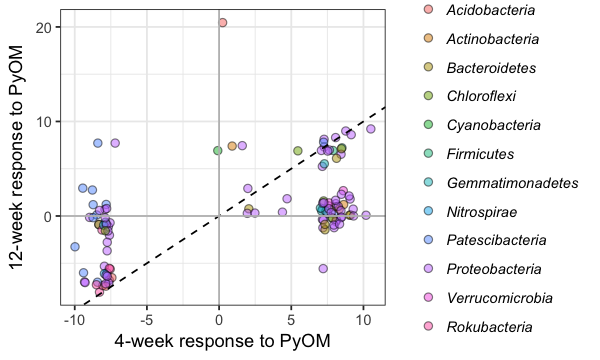

In [195]:
options(repr.plot.width=5, repr.plot.height=3)
# Want to find OTUs with two temperature values
p = ggplot(d.Time.Whitman,aes(x=l2FC.x,y=l2FC.y,fill=Phylum.x))
p = p + geom_point(shape=21, size=2, alpha=0.5) + geom_abline(slope=1,intercept=0,linetype=2) + geom_hline(yintercept=0,linetype=1,color="grey") + geom_vline(xintercept=0,linetype=1,color="grey")
p = p + theme_bw() + theme(legend.text = element_text(face="italic"))
p = p + xlab("1.5-week response to PyOM") + ylab("12-week response to PyOM")
p = p + guides(fill=guide_legend(title="Phylum"))
p

p = ggplot(d.Time.Yao,aes(x=l2FC.x,y=l2FC.y,fill=Phylum.x))
p = p + geom_point(shape=21, size=2, alpha=0.5) + geom_abline(slope=1,intercept=0,linetype=2) + geom_hline(yintercept=0,linetype=1,color="grey") + geom_vline(xintercept=0,linetype=1,color="grey")
p = p + theme_bw() + theme(legend.text = element_text(face="italic"))
p = p + xlab("104-week response to PyOM") + ylab("128-week response to PyOM")
p = p + guides(fill=guide_legend(title="Phylum"))
p

p = ggplot(d.Time.Song,aes(x=l2FC.x,y=l2FC.y,fill=Phylum.x))
p = p + geom_point(shape=21, size=2, alpha=0.5) + geom_abline(slope=1,intercept=0,linetype=2) + geom_hline(yintercept=0,linetype=1,color="grey") + geom_vline(xintercept=0,linetype=1,color="grey")
p = p + theme_bw() + theme(legend.text = element_text(face="italic"))
p = p + xlab("4-week response to PyOM") + ylab("12-week response to PyOM")
p = p + guides(fill=guide_legend(title="Phylum"))
p

# Test slope not different from 1
summary(lm((l2FC.y-l2FC.x)~l2FC.x,d.Time.Whitman))
summary(lm((l2FC.y-l2FC.x)~l2FC.x,d.Time.Yao))
summary(lm((l2FC.y-l2FC.x)~l2FC.x,d.Time.Song))

# Test relationship overall
summary(lm((l2FC.y)~l2FC.x,d.Time.Whitman))
summary(lm((l2FC.y)~l2FC.x,d.Time.Yao))
summary(lm((l2FC.y)~l2FC.x,d.Time.Song))

In [196]:
d.Time = d %>%
    filter(SoilTypeName %in% c("Fragiudept (Whitman)","Mollisol (Yao)","Gleysol (Song)"))

d.Time.Whitman = d.Time %>%
    filter(SoilTypeName == "Fragiudept (Whitman)")
d.Time.Whitman = merge(d.Time.Whitman[d.Time.Whitman$Incubation_Time_Weeks==1.5,],d.Time.Whitman[d.Time.Whitman$Incubation_Time_Weeks==12,],by="OTU")

d.Time.Yao = d.Time %>%
    filter(SoilTypeName == "Mollisol (Yao)")
d.Time.Yao = merge(d.Time.Yao[d.Time.Yao$Incubation_Time_Weeks==104,],d.Time.Yao[d.Time.Yao$Incubation_Time_Weeks==128,],by="OTU")
# Using first and last timepoints

d.Time.Song = d.Time %>%
    filter(SoilTypeName == "Gleysol (Song)")
d.Time.Song = merge(d.Time.Song[d.Time.Song$Incubation_Time_Weeks==4,],d.Time.Song[d.Time.Song$Incubation_Time_Weeks==12,],by="OTU")%>%
    filter(CharType.x==CharType.y)

t.test(d.Time.Whitman$l2FC.y,d.Time.Whitman$l2FC.x, paired=TRUE)
t.test(d.Time.Yao$l2FC.y,d.Time.Yao$l2FC.x, paired=TRUE)
t.test(d.Time.Song$l2FC.y,d.Time.Song$l2FC.x, paired=TRUE)


	Paired t-test

data:  d.Time.Whitman$l2FC.y and d.Time.Whitman$l2FC.x
t = -3.9837, df = 942, p-value = 7.308e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.25800946 -0.08770188
sample estimates:
mean of the differences 
             -0.1728557 



	Paired t-test

data:  d.Time.Yao$l2FC.y and d.Time.Yao$l2FC.x
t = 2.2121, df = 697, p-value = 0.02729
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.03300956 0.55423958
sample estimates:
mean of the differences 
              0.2936246 



	Paired t-test

data:  d.Time.Song$l2FC.y and d.Time.Song$l2FC.x
t = 4.1629, df = 1926, p-value = 3.281e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2212417 0.6153934
sample estimates:
mean of the differences 
              0.4183176 


In [346]:
SigStudies = d %>%
    group_by(OTU,SoilTypeName,CharType)%>%
    summarize(AnySig = ifelse(sum(Sig == "significant"),1,0))%>%
    filter(AnySig>0)%>%
    group_by(OTU)

In [347]:
SigStudies[SigStudies$OTU %in% c("Mesorhizobium", "Nocardioides","Noviherbaspirillum"),]

OTU,SoilTypeName,CharType,AnySig
Mesorhizobium,Argiustoll (Dai),Manure300,1
Mesorhizobium,Argiustoll (Dai),Manure700,1
Mesorhizobium,Gleysol (Song),Wheat300,1
Mesorhizobium,Psammaquent (Dai),Manure300,1
Nocardioides,Argiustoll (Dai),Manure300,1
Nocardioides,Argiustoll (Dai),Manure700,1
Nocardioides,Gleysol (Song),Wheat300,1
Nocardioides,Psammaquent (Dai),Manure700,1
Noviherbaspirillum,Fragiudept (Whitman),Corn350,1
Noviherbaspirillum,Gleysol (Song),Wheat300,1


In [198]:
# For each OTU, how many studies found it significant somewhere?
nSigStudies = d %>%
    group_by(Genus,OTU,SoilTypeName)%>%
    summarize(AnySig = sum(Sig == "significant" & l2FC>0))%>%
    group_by(Genus,OTU)%>%
    filter(AnySig>0)%>%
    summarize(TotSig = sum(AnySig>0))%>%
    arrange(-TotSig)
dim(nSigStudies)
dim(nSigStudies[nSigStudies$TotSig==3,])
dim(nSigStudies[nSigStudies$TotSig==2,])
dim(nSigStudies[nSigStudies$TotSig==1,])
nSigStudies[nSigStudies$TotSig==2,]

[1] 447   3

[1] 1 3

[1] 12  3

[1] 434   3

Genus,OTU,TotSig
Bryobacter,c9318aead8ebac5cad2bd9a1176ef066,2
Pseudonocardia,f8aa3538e9a9569bd56377be5435dd98,2
Reyranella,939ad597b7fb9ea8c833b95d46a6f583,2
Reyranella,bcb4f6228b75b332595b7b72ddaee928,2
Streptomyces,a1cacf297e7f8f9c5ab680faf43a02f2,2
uncultured,56385bec75037b542af8fa9b045d9b7a,2
uncultured,8d7794c21ec27c9cde80a8a13be41c92,2
Kribbella,067f349d1935e4af71fab37234ed8e83,2
Mesorhizobium,9722830c6b7db25b76f05adb87c84aa1,2
Nonomuraea,5121af7432439a6dbe45a5b0c0fb7b31,2


## L2FC vs delta pH

In [1]:
library(vegan)

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-6


In [24]:
ps = readRDS("ps.glom.genus.ps")
# Import ps object

# Adjust pH for Xu
sample_data(ps)["B0-X","pH"] = 7.84
sample_data(ps)["B1-X","pH"] = NA
sample_data(ps)["B2-X","pH"] = 8.17
sample_data(ps)["B4-X","pH"] = 8.21
sample_data(ps)["B8-X","pH"] = 8.25

In [25]:
ps = subset_samples(ps, Incubation_Time_Weeks != 0)
ps = subset_samples(ps, PyOM != "OM")
# Remove the initial measurements and the OM only treatments

sample_data(ps)$SoilTypeName = paste(sample_data(ps)$SoilType," (",sample_data(ps)$Author,")",sep="")
# Create a variable that separates by studies / soil type

sample_data(ps)$Feedstock_Category = ifelse(sample_data(ps)$Feedstock %in% c('commercial cornstock powder', 'corn stover', 'corncob',"Corn Straw","Stover"), "Corn",
                                   ifelse(sample_data(ps)$Feedstock %in% c('wheat straw','winter wheat'),"Wheat",
                                          ifelse(sample_data(ps)$Feedstock %in% c('Jarrah wood'),"Eucalyptus",
                                                 ifelse(sample_data(ps)$Feedstock =='Manure', "Manure","Unknown"))))
# Rename the feedstocks for consistency

sample_data(ps)$CharType = ifelse(sample_data(ps)$PyOM=="PyOM",paste(sample_data(ps)$Feedstock_Category,sample_data(ps)$PyOM.Temp,sep=""),"Control")
#sample_data(ps)$CharType = ifelse(sample_data(ps)$PyOM=="PyOM",sample_data(ps)$Feedstock_Category,"Control")
levels(as.factor(sample_data(ps)$CharType))
# These are all the PyOM samples we will want to test.

ps = subset_samples(ps, !(Author == "Song" & SoilType == "Gleysol" & Incubation_Time_Weeks == 24))
# Removing one set of samples that we know doesn't have a control

[1] "Control"       "Corn"          "Corn350"       "Corn450"      
 [5] "Corn500"       "Corn550"       "Eucalyptus600" "Manure300"    
 [9] "Manure550"     "Manure700"     "Wheat300"      "Wheat600"     
[13] "Wheat750"

In [26]:
SamplesToTest = sample_names(sample_data(ps)[sample_data(ps)$PyOM != "Control"])
# Get list of PyOM-containing samples

In [27]:
n = 1
# Establish counter at 1

DistanceSummary = sample_data(ps)[1,]
DistanceSummary$pHControl = 0
DistanceSummary$i=""
DistanceSummary$j=""
DistanceSummary$Dist=0
# Create empty data frame

In [28]:
# Running loop to go through and pull out the data associated with the sample of interest,
# Find its possible relevant control samples
# And then calculate and store dissimilarities

for (i in SamplesToTest){
    SoilTypeNamei = sample_data(ps)[i]$SoilTypeName
    Feedstock_Categoryi = sample_data(ps)[i]$Feedstock_Category
    CharTypei = sample_data(ps)[i]$CharType
    Incubation_Time_Weeksi = sample_data(ps)[i]$Incubation_Time_Weeks
    samdat = data.frame(sample_data(ps)[i])
    ps.test = subset_samples(ps,Incubation_Time_Weeks == Incubation_Time_Weeksi & SoilTypeName == SoilTypeNamei)
    ControlSamplesToCompare = sample_names(sample_data(ps.test)[sample_data(ps.test)$PyOM == "Control"])
    for (j in ControlSamplesToCompare){
        pHControl = sample_data(subset_samples(ps.test, sample_names(ps.test) == j))$pH
        distance = vegdist(t(otu_table(subset_samples(ps.test, sample_names(ps.test) %in% c(i,j)))),distance="bray",upper=FALSE)
        DataEntry = data.frame(samdat,pHControl,i, j, distance[1])
        DistanceSummary[n,]=DataEntry[1,]
        DistanceSummary[n,dim(DistanceSummary)[2]-3]=pHControl
        DistanceSummary[n,dim(DistanceSummary)[2]-2]=i
        DistanceSummary[n,dim(DistanceSummary)[2]-1]=j
        n = n+1
    }
    
}

Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Apr-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Apr-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Apr-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Apr-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Apr-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Apr-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Apr-14", class = "factor")):
“invalid factor level, NA ge

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Aug-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Aug-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Aug-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Aug-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Aug-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Aug-14", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "Aug-14", class = "fac

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor leve

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor leve

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "15", class = "factor")):
“invalid factor leve

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "7581.61", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "7581.61", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "7581.61", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.1T.20.1", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.1T.20.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.1T.20.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7"

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.1T.26.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.1T.26.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3"

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.1T.3.1", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.1T.3.1", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BM

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.1T.3.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.1T.3.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", 

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.5T.18.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.5T.18.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = 

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.5T.21.1", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.5T.21.1", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = 

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.5T.21.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.5T.21.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = 

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.5T.5.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.7.5T.5.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "f

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.1T.11.1", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.1T.11.1", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3"

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.1T.11.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.1T.11.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.1T.30.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.1T.30.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "44.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "10.7"

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.5T.17.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.5T.17.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = 

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.5T.2.1", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.5T.2.1", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "f

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.5T.2.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.5T.2.3", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "f

“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.5T.23.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "16", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "1721.BMC.8.5T.23.2", class = "factor")):
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, iseq, value = structure(1L, .Label = "57", class = 

In [29]:
DistanceSummary$Incubation_Time_Weeks = as.numeric(DistanceSummary$Incubation_Time_Weeks)
DistanceSummary$Dist = as.numeric(DistanceSummary$Dist)
DistanceSummary$g.per.kg.PyOM = as.numeric(DistanceSummary$g.per.kg.PyOM)
DistanceSummary$t.per.ha.PyOM = as.numeric(DistanceSummary$t.per.ha.PyOM)
DistanceSummary$pH = as.numeric(DistanceSummary$pH)
DistanceSummary$pHControl = as.numeric(DistanceSummary$pHControl)
DistanceSummary$pHDiff = DistanceSummary$pH - DistanceSummary$pHControl

In [30]:
# Summarize within relevant sample sets
pHShifts = DistanceSummary%>%
    group_by(SoilTypeName,pHDiff,CharType,Incubation_Time_Weeks,Feedstock,Feedstock_Category,PyOM.Temp)%>%
    summarize(MeanDist=mean(Dist))%>%
    filter(!is.na(pHDiff))


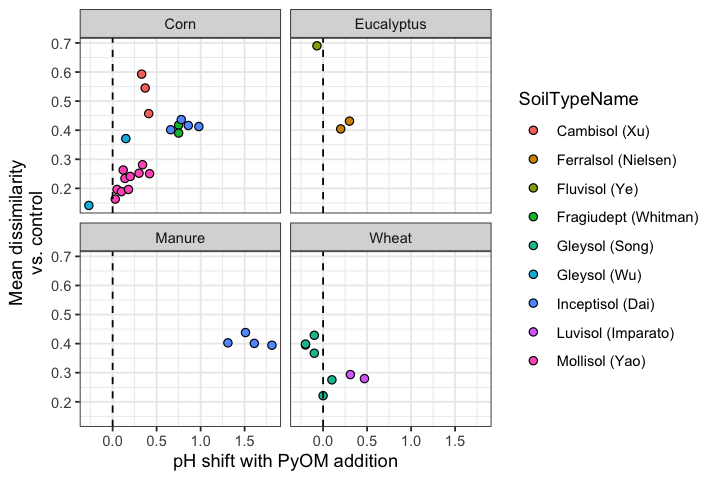

In [31]:
options(repr.plot.width=6, repr.plot.height=4)
p = ggplot(pHShifts,aes(x=pHDiff,y=MeanDist,fill=SoilTypeName))
p = p + geom_point(shape=21,size=2) + facet_wrap(~Feedstock_Category,ncol=2) + theme_bw()+geom_vline(xintercept=0,linetype="dashed")
p = p + ylab("Mean dissimilarity\nvs. control")+xlab("pH shift with PyOM addition")
p